<a href="https://colab.research.google.com/github/suzzini/DS_Study/blob/main/coronadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

한글 깨짐 문제 해결

In [ ]:
#해당 셀 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#설정 변환을 위해서 matplotlib만 import
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# MacOS
#mpl.rc("font", family='AppleGothic')

In [5]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from datetime import date, datetime 

def getCovid19Info(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19GenAgeCaseInfJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [6]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') }

In [7]:
def parsing(items):
  item_list = [] 

  for item in items: 
    item_dict = {} 
    for tag in list(item): 
      try: 
        item_dict[tag.name] = convert_method[tag.name](tag.text) 
      except Exception: 
        item_dict[tag.name] = None 
    item_list.append(item_dict) 
    
  df = pd.DataFrame(item_list)
  return df

### 1. 성별,연령별 

In [8]:
#가져오고 싶은 날짜 지정하여 데이터 가져오기
temp = getCovid19Info(date(2020,12,31), date(2021, 7, 9)) 
items = temp.find('items') 
df=parsing(items)

In [9]:
#필요한 열만 추출
df=df[['confcase','createdt','death','deathrate','gubun']]
df['createdt']=df['createdt'].dt.strftime('%Y-%m-%d')

In [10]:
#성별 비율은 거의 비슷해서 제외
df=df[~(df['gubun']=='여성') & ~(df['gubun']=='남성')]
df=df.reset_index()
df=df.iloc[:,1:]

In [11]:
#gubun이 총 9씩 있는지 확인하기
check9=pd.DataFrame(df.groupby('createdt').count()['gubun'])
check9=check9.reset_index()
check9[check9['gubun']!=9]

,createdt,gubun
65,2021-03-06,17
117,2021-04-27,8
166,2021-06-15,8


누적 확진자의 수치를 계산하여 결측치 채우기

In [12]:
## 원하는 위치에 넣기
new_data = {
    'confcase' : 22697,
    'createdt' : '2021-06-15',
    'death' : 0,
    'deathrate':0,
    'gubun':'40-49'
}

idx = 220 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [13]:
## 원하는 위치에 넣기2
new_data = {
    'confcase' : 16114,
    'createdt' : '2021-04-27',
    'death' : 0,
    'deathrate':0,
    'gubun':'30-39'
}

idx = 659 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [14]:
df[(df['createdt']=='2021-03-06')]

,confcase,createdt,death,deathrate,gubun
891,3775,2021-03-06,0,0.00,0-9
892,6229,2021-03-06,0,0.00,10-19
893,13903,2021-03-06,1,0.06,20-29
894,12094,2021-03-06,6,0.37,30-39
895,13245,2021-03-06,14,0.86,40-49
896,17095,2021-03-06,54,3.31,50-59
897,14329,2021-03-06,186,11.40,60-69
898,6935,2021-03-06,450,27.57,70-79
899,4447,2021-03-06,921,56.43,80 이상
1143,3775,2021-03-06,0,0.00,0-9


2021-03-06의 경우 데이터가 중복되어있음을 확인
필요없는 행은 제거 해주기로 함.

In [15]:
df=df.drop([1143,1144,1145,1146,1147,1148,1149,1150])
df=df.reset_index()
df=df.drop('index',axis=1)

날짜, gubun 순으로 정렬하기
  - 정렬을 위해 다음과 같이 replace 함.

In [16]:
df=df.replace('0-9', 'a.0-9')
df=df.replace('10-19', 'b.10-19')
df=df.replace('20-29', 'c.20-29')
df=df.replace('30-39', 'd.30-39')
df=df.replace('40-49', 'e.40-49')
df=df.replace('50-59', 'f.50-59')
df=df.replace('60-69', 'g.60-69')
df=df.replace('70-79', 'h.70-79')
df=df.replace('80 이상', 'i.80 이상')

In [17]:
df=df.sort_values(by=['createdt','gubun'], axis=0)
df=df.reset_index()
df=df.drop('index',axis=1)
df

,confcase,createdt,death,deathrate,gubun
0,2091,2020-12-31,0,0.00,a.0-9
1,3770,2020-12-31,0,0.00,b.10-19
2,9705,2020-12-31,0,0.00,c.20-29
3,7728,2020-12-31,3,0.33,d.30-39
4,8624,2020-12-31,7,0.78,e.40-49
...,...,...,...,...,...
1714,25784,2021-07-09,15,0.74,e.40-49
1715,30123,2021-07-09,73,3.59,f.50-59
1716,23547,2021-07-09,245,12.03,g.60-69
1717,10437,2021-07-09,583,28.63,h.70-79


### 연령별 일일 확진자 구하기

In [18]:
forday=df['confcase'].reset_index()['confcase']
forday.index=forday.index+9

In [19]:
df['ofday']=forday
df['ofday']=df['ofday'].fillna(0)

In [20]:
df['realofday']=df['confcase']-df['ofday']
df[:20]

,confcase,createdt,death,deathrate,gubun,ofday,realofday
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0
5,11398,2020-12-31,30,3.33,f.50-59,0.0,11398.0
6,9632,2020-12-31,106,11.78,g.60-69,0.0,9632.0
7,4769,2020-12-31,258,28.67,h.70-79,0.0,4769.0
8,3023,2020-12-31,496,55.11,i.80 이상,0.0,3023.0
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0


In [21]:
realreal=df['realofday'][9:]
realreal.index=realreal.index-9
realreal

0        41.0
1        74.0
2       131.0
3       145.0
4       154.0
        ...  
1705    235.0
1706    222.0
1707     77.0
1708     15.0
1709      7.0
Name: realofday, Length: 1710, dtype: float64

In [22]:
df['realreal']=realreal
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0,41.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0,74.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0,131.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0,145.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0,154.0
...,...,...,...,...,...,...,...,...
1714,25784,2021-07-09,15,0.74,e.40-49,25549.0,235.0,NaN
1715,30123,2021-07-09,73,3.59,f.50-59,29901.0,222.0,NaN
1716,23547,2021-07-09,245,12.03,g.60-69,23470.0,77.0,NaN
1717,10437,2021-07-09,583,28.63,h.70-79,10422.0,15.0,NaN


In [23]:
#2021-01-01 이후 행만 추출
df=df[(df['createdt']>='2021-01-01') & (df['createdt']<='2021-07-08')]
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0,39.0
10,3844,2021-01-01,0,0.00,b.10-19,3770.0,74.0,66.0
11,9836,2021-01-01,0,0.00,c.20-29,9705.0,131.0,111.0
12,7873,2021-01-01,4,0.44,d.30-39,7728.0,145.0,109.0
13,8778,2021-01-01,7,0.76,e.40-49,8624.0,154.0,106.0
...,...,...,...,...,...,...,...,...
1705,25549,2021-07-08,15,0.74,e.40-49,25330.0,219.0,235.0
1706,29901,2021-07-08,73,3.59,f.50-59,29687.0,214.0,222.0
1707,23470,2021-07-08,245,12.05,g.60-69,23408.0,62.0,77.0
1708,10422,2021-07-08,583,28.66,h.70-79,10401.0,21.0,15.0


전처리 완료.

In [24]:
df=df[['confcase','createdt','gubun','realreal']]
df=df.reset_index()

In [25]:
df=df.drop('index',axis=1)
df

,confcase,createdt,gubun,realreal
0,2132,2021-01-01,a.0-9,39.0
1,3844,2021-01-01,b.10-19,66.0
2,9836,2021-01-01,c.20-29,111.0
3,7873,2021-01-01,d.30-39,109.0
4,8778,2021-01-01,e.40-49,106.0
...,...,...,...,...
1696,25549,2021-07-08,e.40-49,235.0
1697,29901,2021-07-08,f.50-59,222.0
1698,23470,2021-07-08,g.60-69,77.0
1699,10422,2021-07-08,h.70-79,15.0


1) 연령 구분 없이 하루 확진자 수 구하기

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
foraccumulate=df.groupby('createdt').sum()['confcase']
foraccumulate=foraccumulate.reset_index()

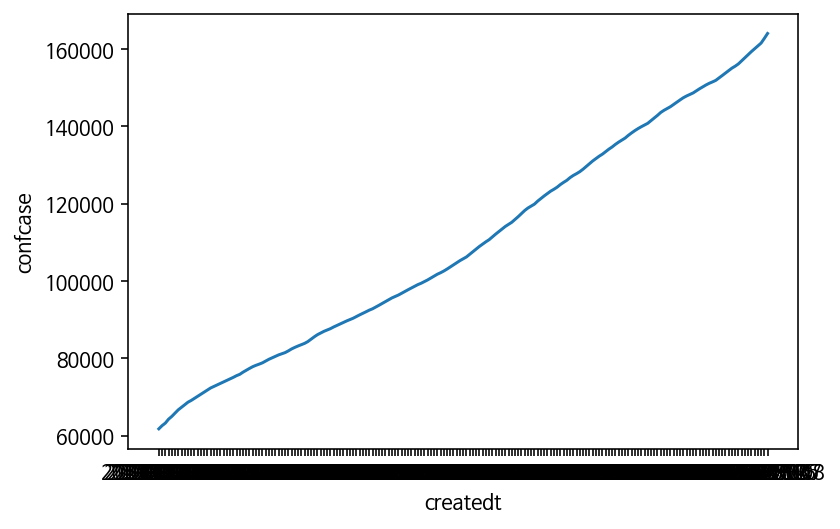

In [28]:
sns.lineplot(data=foraccumulate,x='createdt',y='confcase')

In [29]:
final_forday=pd.DataFrame(df.groupby('createdt').sum()['realreal'])
final_forday=final_forday.reset_index()

In [30]:
final_forday

,createdt,realreal
0,2021-01-01,824.0
1,2021-01-02,651.0
2,2021-01-03,1020.0
3,2021-01-04,715.0
4,2021-01-05,839.0
...,...,...
184,2021-07-04,711.0
185,2021-07-05,746.0
186,2021-07-06,1212.0
187,2021-07-07,1275.0


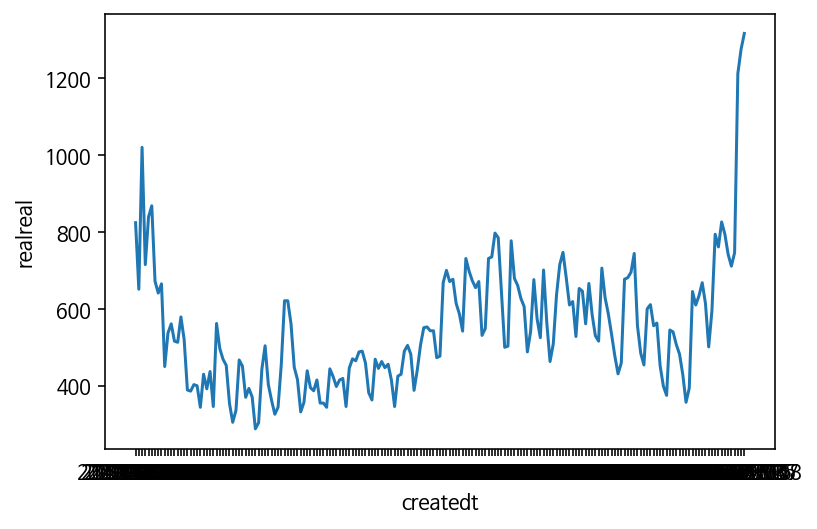

In [31]:
sns.lineplot(data=final_forday,x='createdt',y='realreal')

In [32]:
df[df['gubun']=='a.0-9'][['createdt','realreal']]

,createdt,realreal
0,2021-01-01,39.0
9,2021-01-02,32.0
18,2021-01-03,40.0
27,2021-01-04,45.0
36,2021-01-05,45.0
...,...,...
1656,2021-07-04,43.0
1665,2021-07-05,42.0
1674,2021-07-06,33.0
1683,2021-07-07,57.0


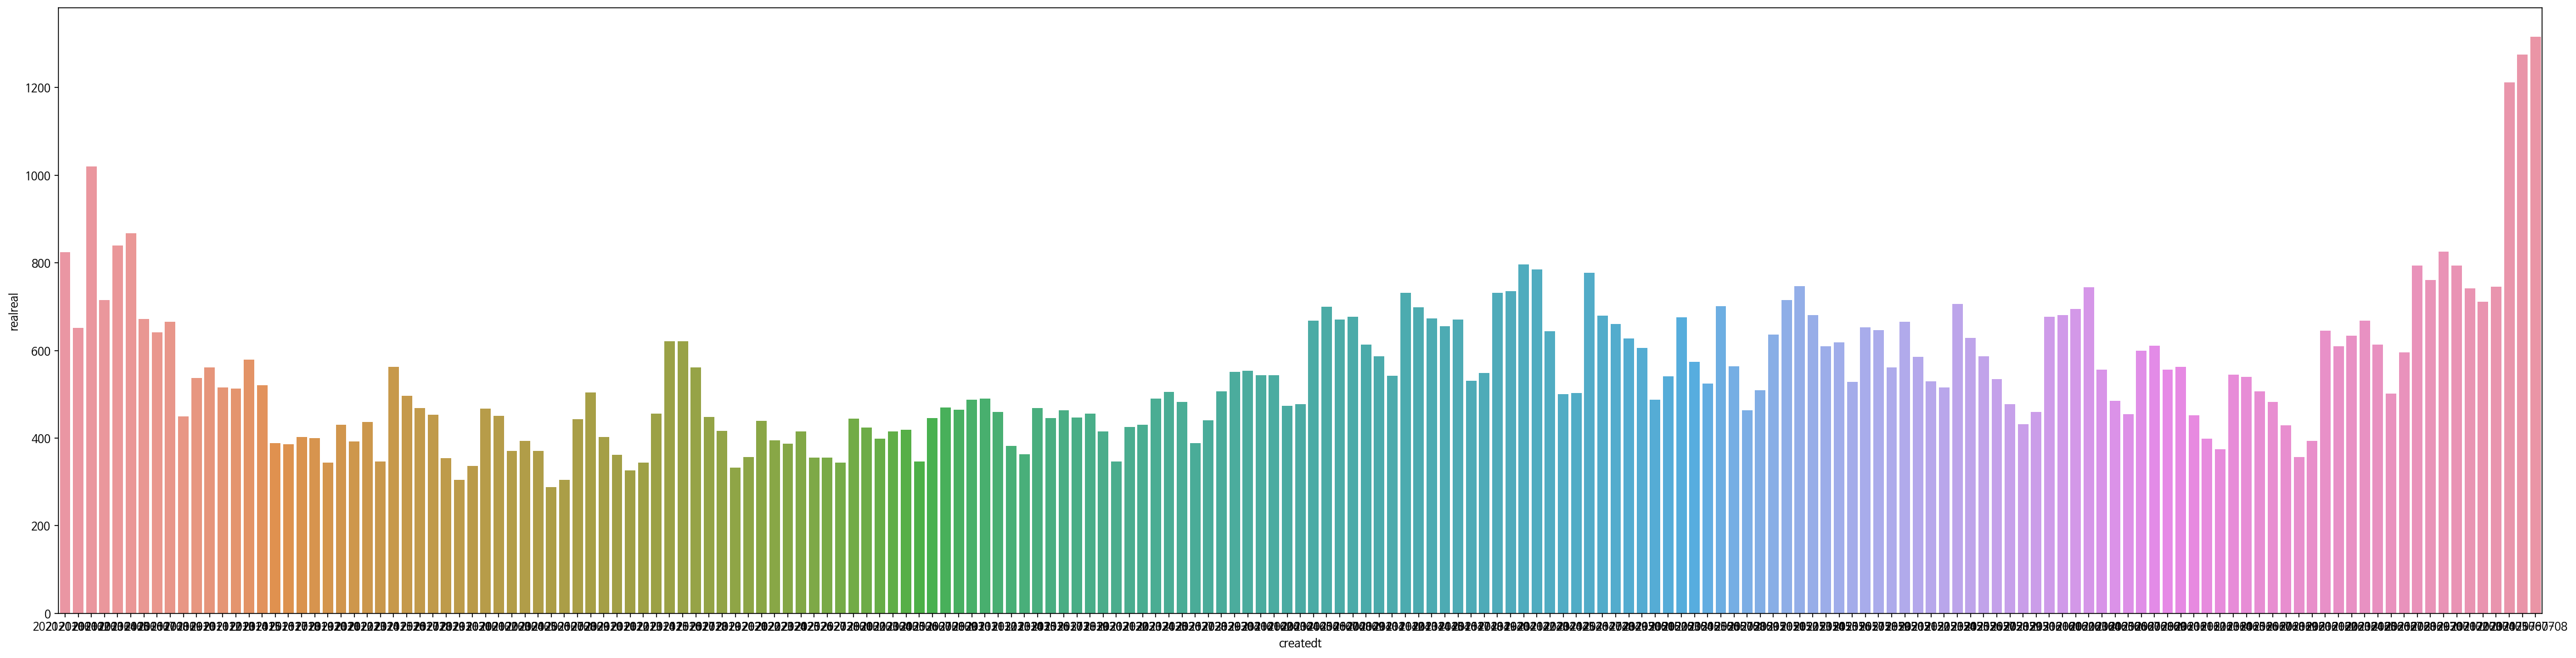

In [33]:
plt.figure(figsize=(40,10))
sns.barplot(data=final_forday,x='createdt',y='realreal')

신규+누적확진자

In [34]:
#1월 확진자
sum(df[:9]['realreal'])

824.0

In [35]:
61769-824

60945

In [36]:
foraccumulate['since2021']=foraccumulate['confcase']-60945

In [37]:
foraccumulate

,createdt,confcase,since2021
0,2021-01-01,61769,824
1,2021-01-02,62593,1648
2,2021-01-03,63244,2299
3,2021-01-04,64264,3319
4,2021-01-05,64979,4034
...,...,...,...
184,2021-07-04,160084,99139
185,2021-07-05,160795,99850
186,2021-07-06,161541,100596
187,2021-07-07,162753,101808


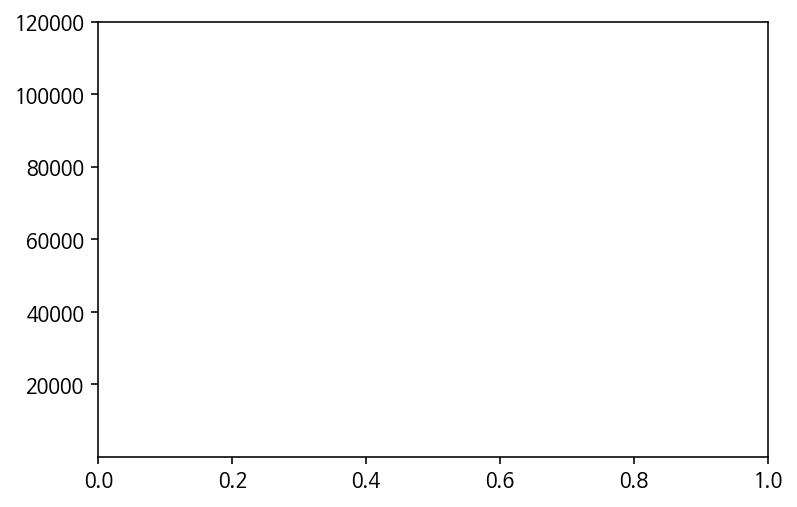

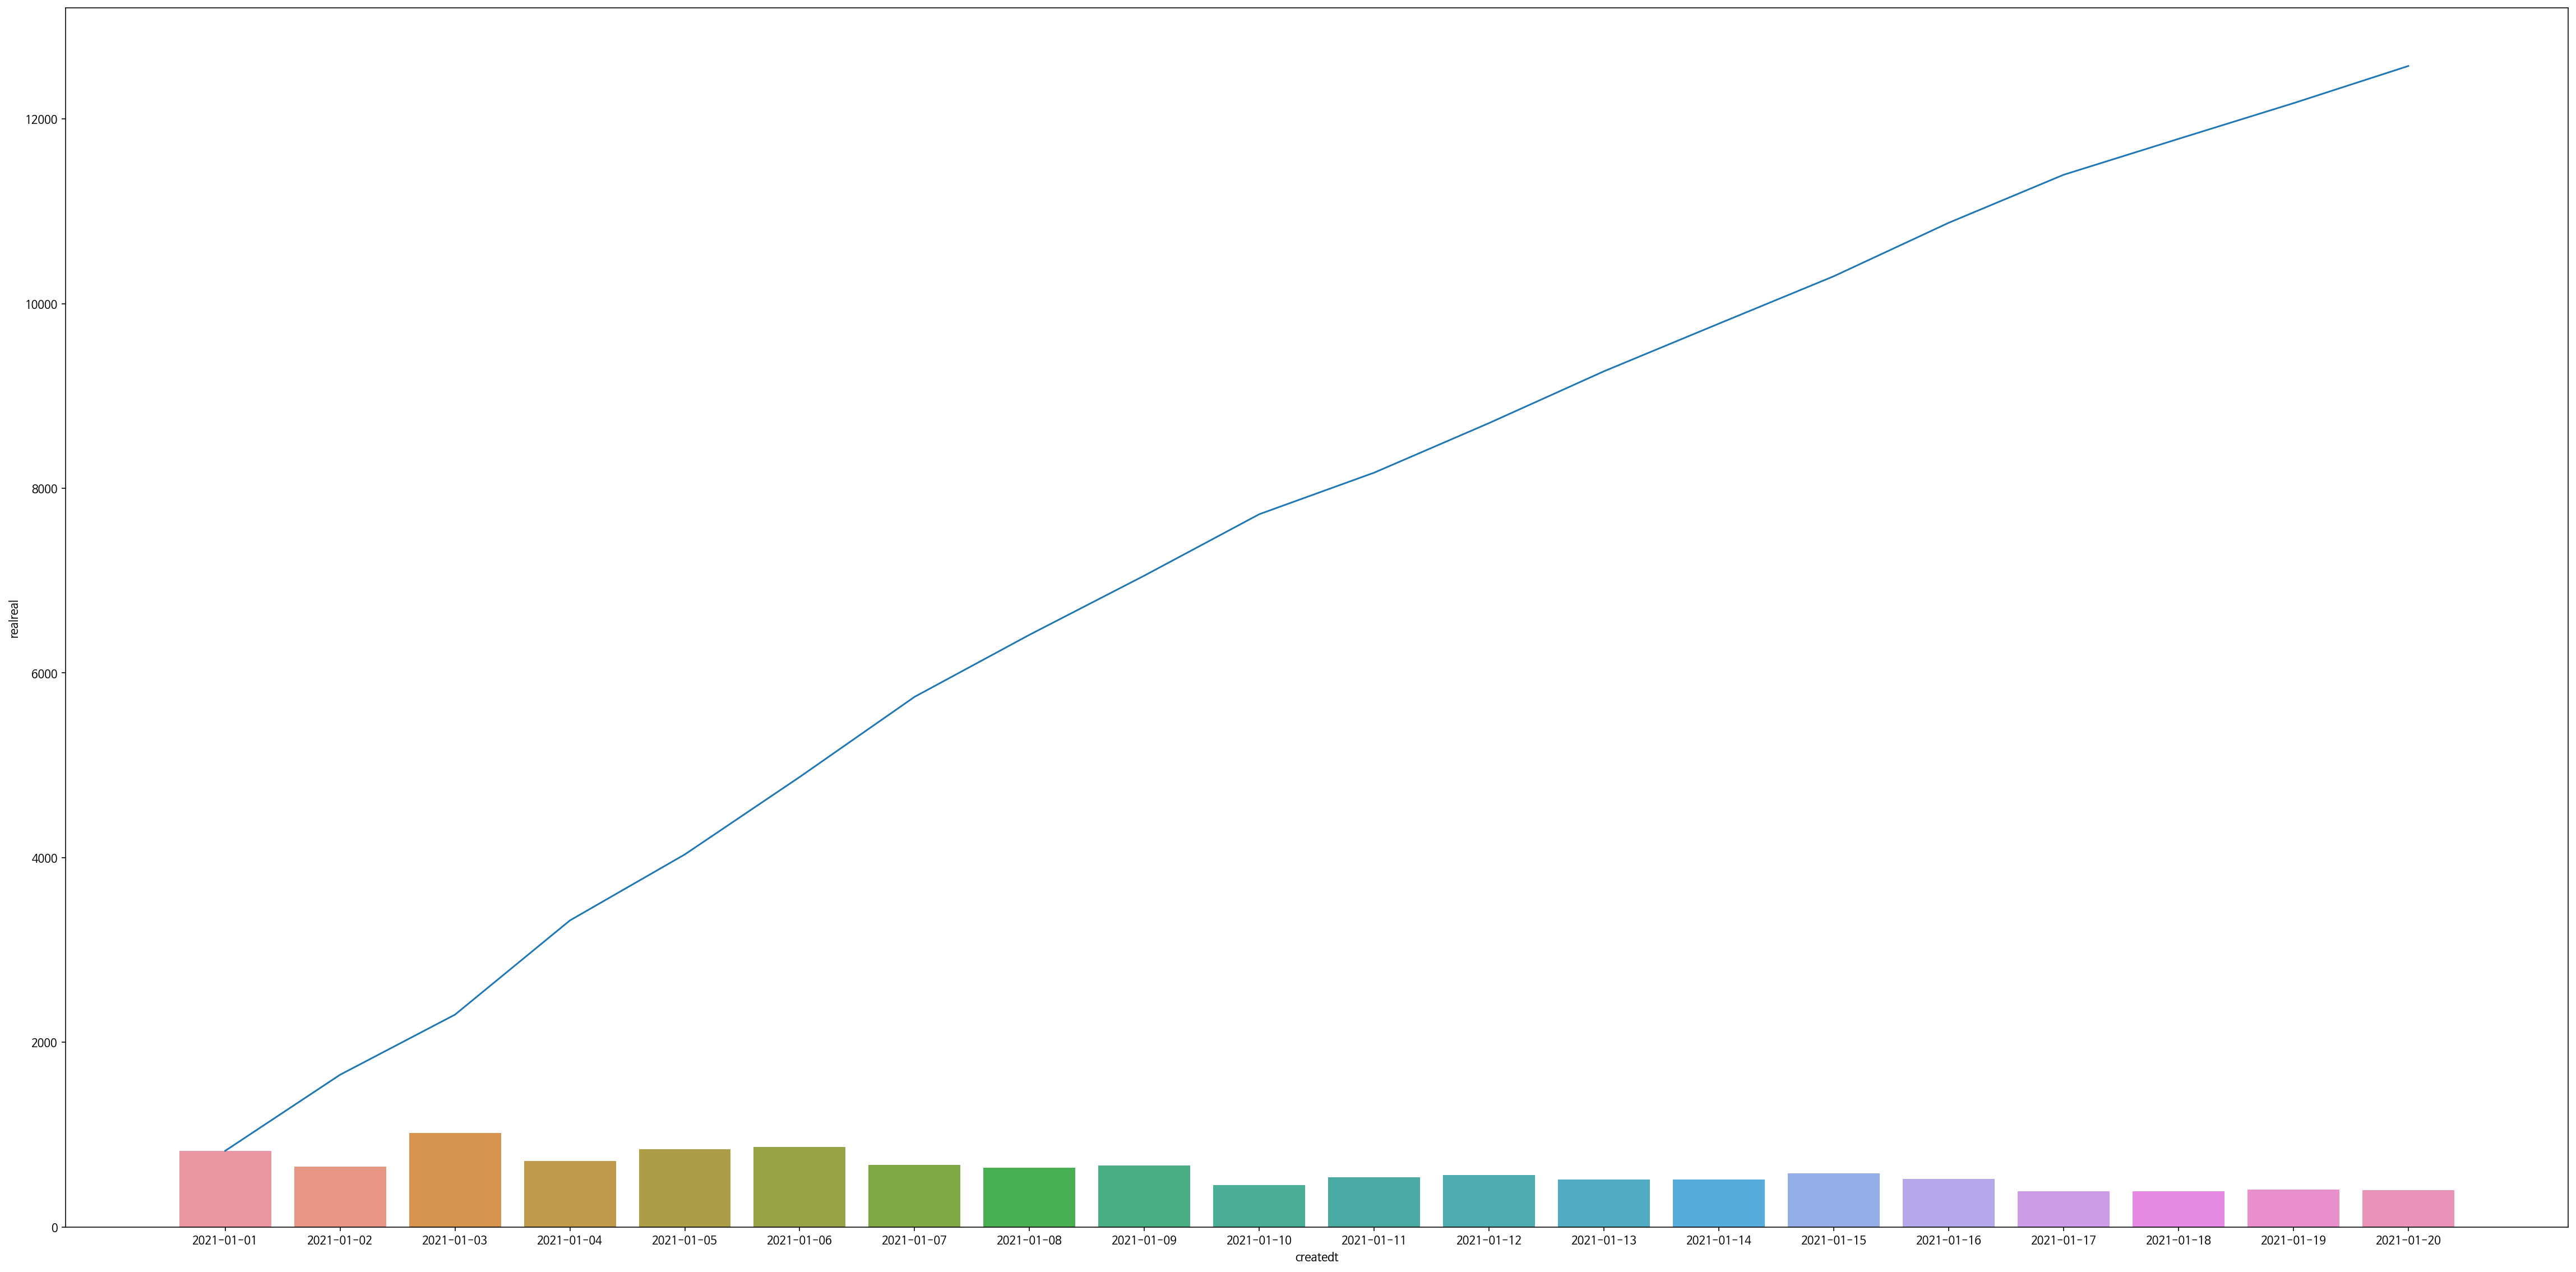

In [38]:
import matplotlib.pyplot as plt
plt.ylim(100, 120000)
plt.figure(figsize=(40,20))

sns.barplot(data=final_forday[:20],x='createdt',y='realreal')
sns.lineplot(data=foraccumulate[:20],x='createdt',y='since2021')

### [시각화] 연령대 별 확진자(날짜 기준2개)


In [39]:
#7/1
period1=df[(df['createdt']>'2021-06-31') ]
period2=df[(df['createdt']<='2021-06-30') & (df['createdt']>='2021-06-24') ]

In [40]:
period1=pd.DataFrame(period1.groupby(['gubun']).sum()['realreal'])
period1=period1.reset_index()
period1=period1.rename(columns={'realreal':'daily'})
period1['period']=1
period1

,gubun,daily,period
0,a.0-9,364.0,1
1,b.10-19,771.0,1
2,c.20-29,1926.0,1
3,d.30-39,1321.0,1
4,e.40-49,1421.0,1
5,f.50-59,1249.0,1
6,g.60-69,427.0,1
7,h.70-79,101.0,1
8,i.80 이상,42.0,1


In [41]:
period2=pd.DataFrame(period2.groupby(['gubun']).sum()['realreal'])
period2=period2.reset_index()
period2=period2.rename(columns={'realreal':'daily'})
period2['period']=2
period2.head()

,gubun,daily,period
0,a.0-9,294.0,2
1,b.10-19,403.0,2
2,c.20-29,1006.0,2
3,d.30-39,828.0,2
4,e.40-49,817.0,2


In [42]:
insight_1=pd.concat([period1,period2])
insight_1.head()

,gubun,daily,period
0,a.0-9,364.0,1
1,b.10-19,771.0,1
2,c.20-29,1926.0,1
3,d.30-39,1321.0,1
4,e.40-49,1421.0,1


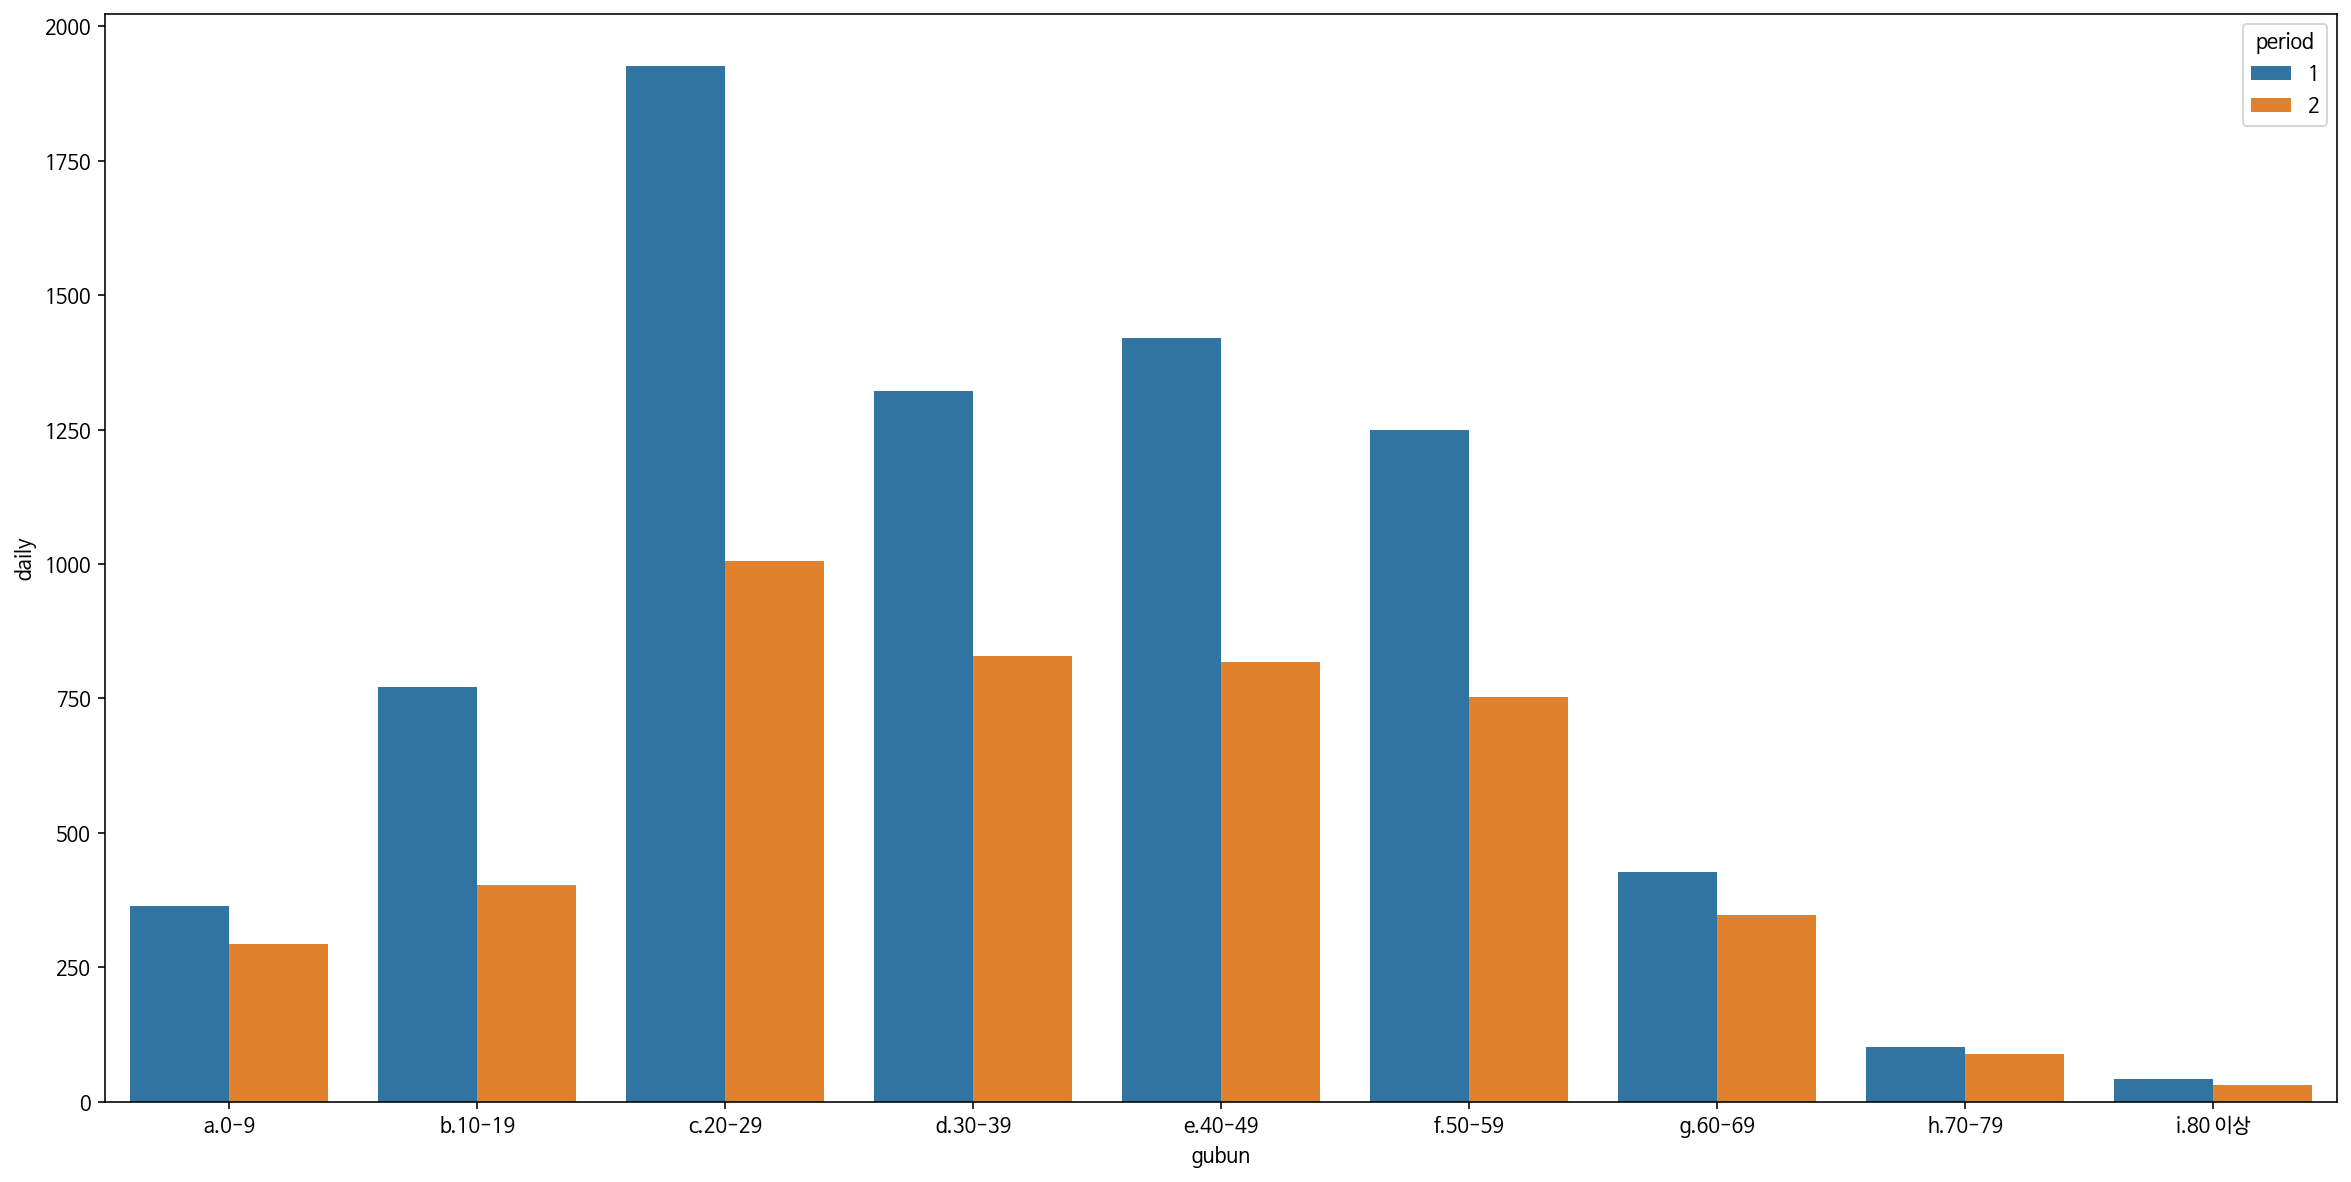

In [43]:
plt.figure(figsize=(20,10))
sns.barplot(x='gubun', y='daily',hue='period', data=insight_1); # default : dodge=True

In [44]:
df[df['createdt']=='2021-07-08']

,confcase,createdt,gubun,realreal
1692,7487,2021-07-08,a.0-9,66.0
1693,12060,2021-07-08,b.10-19,133.0
1694,25916,2021-07-08,c.20-29,323.0
1695,23287,2021-07-08,d.30-39,238.0
1696,25549,2021-07-08,e.40-49,235.0
1697,29901,2021-07-08,f.50-59,222.0
1698,23470,2021-07-08,g.60-69,77.0
1699,10422,2021-07-08,h.70-79,15.0
1700,5936,2021-07-08,i.80 이상,7.0


### 2. 지역별 발생현황

In [45]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from datetime import date, datetime 

def getCovid19Info_2(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [46]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') ,
    'gubun':str,
    'incdec':int, #전일대비 증감 수
    'defcnt':int, #DEF_CNT
    'localocccnt':int, #지역발생 수
    'deathcnt':int, #사망자 수
    'isolclearcnt':int,
    'isolingcnt':int,
    'overflowcnt':int,
    'qurrate':float,
    'stdday':str
    }

In [47]:
temp = getCovid19Info_2(date(2021,1,1), date(2021, 7, 9)) 
items = temp.find('items') 
df_2=parsing(items)

In [48]:
df_2

,createdt,deathcnt,defcnt,gubun,gubuncn,gubunen,incdec,isolclearcnt,isolingcnt,localocccnt,overflowcnt,qurrate,seq,stdday,updatedt
0,2021-07-09 09:43:18.968,5,4492,검역,None,None,39,4104,383,0,39,NaN,10628,2021년 07월 09일 00시,None
1,2021-07-09 09:43:18.968,1,1352,제주,None,None,31,1255,96,30,1,200.40,10627,2021년 07월 09일 00시,None
2,2021-07-09 09:43:18.968,21,5378,경남,None,None,17,5186,171,17,0,161.01,10626,2021년 07월 09일 00시,None
3,2021-07-09 09:43:18.968,86,5017,경북,None,None,9,4839,92,9,0,190.08,10625,2021년 07월 09일 00시,None
4,2021-07-09 09:43:18.967,17,1698,전남,None,None,5,1584,97,5,0,91.71,10624,2021년 07월 09일 00시,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,2021-01-01 09:41:33.330,29,2904,인천,None,None,65,2150,725,63,2,35.93,6757,2021년 01월 01일 00시,None
3606,2021-01-01 09:41:33.330,201,7844,대구,None,None,43,7294,349,43,0,294.85,6756,2021년 01월 01일 00시,None
3607,2021-01-01 09:41:33.330,50,1925,부산,None,None,57,1370,505,55,2,17.59,6755,2021년 01월 01일 00시,None
3608,2021-01-01 09:41:33.330,182,19362,서울,None,None,358,10787,8393,357,1,64.44,6754,2021년 01월 01일 00시,None


In [49]:
import datetime
df_2['createdt']=df_2['createdt']- datetime.timedelta(days=1)

In [50]:
df_2

,createdt,deathcnt,defcnt,gubun,gubuncn,gubunen,incdec,isolclearcnt,isolingcnt,localocccnt,overflowcnt,qurrate,seq,stdday,updatedt
0,2021-07-08 09:43:18.968,5,4492,검역,None,None,39,4104,383,0,39,NaN,10628,2021년 07월 09일 00시,None
1,2021-07-08 09:43:18.968,1,1352,제주,None,None,31,1255,96,30,1,200.40,10627,2021년 07월 09일 00시,None
2,2021-07-08 09:43:18.968,21,5378,경남,None,None,17,5186,171,17,0,161.01,10626,2021년 07월 09일 00시,None
3,2021-07-08 09:43:18.968,86,5017,경북,None,None,9,4839,92,9,0,190.08,10625,2021년 07월 09일 00시,None
4,2021-07-08 09:43:18.967,17,1698,전남,None,None,5,1584,97,5,0,91.71,10624,2021년 07월 09일 00시,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,2020-12-31 09:41:33.330,29,2904,인천,None,None,65,2150,725,63,2,35.93,6757,2021년 01월 01일 00시,None
3606,2020-12-31 09:41:33.330,201,7844,대구,None,None,43,7294,349,43,0,294.85,6756,2021년 01월 01일 00시,None
3607,2020-12-31 09:41:33.330,50,1925,부산,None,None,57,1370,505,55,2,17.59,6755,2021년 01월 01일 00시,None
3608,2020-12-31 09:41:33.330,182,19362,서울,None,None,358,10787,8393,357,1,64.44,6754,2021년 01월 01일 00시,None


In [51]:
from datetime import date, datetime 
df_2=df_2[['createdt','deathcnt','defcnt','gubun','incdec']]
df_2['createdt']=df_2['createdt'].dt.strftime('%Y-%m-%d')
df_2

,createdt,deathcnt,defcnt,gubun,incdec
0,2021-07-08,5,4492,검역,39
1,2021-07-08,1,1352,제주,31
2,2021-07-08,21,5378,경남,17
3,2021-07-08,86,5017,경북,9
4,2021-07-08,17,1698,전남,5
...,...,...,...,...,...
3605,2020-12-31,29,2904,인천,65
3606,2020-12-31,201,7844,대구,43
3607,2020-12-31,50,1925,부산,57
3608,2020-12-31,182,19362,서울,358


In [52]:
df_2=df_2[df_2['createdt']>='2021-01-01']

모든 날짜에 19개의 지역별로 데이터가 잘 있는지 확인

In [53]:
check19=pd.DataFrame(df_2.groupby('createdt').count()['gubun'])
check19=check19.reset_index()

In [54]:
check19[check19['gubun']!=19]

,createdt,gubun


In [55]:
df_2.isnull().sum()

createdt    0
deathcnt    0
defcnt      0
gubun       0
incdec      0
dtype: int64

In [56]:
df_2[df_2['gubun']=='합계'].head()

,createdt,deathcnt,defcnt,gubun,incdec
18,2021-07-08,2036,165344,합계,1316
37,2021-07-07,2034,164028,합계,1275
56,2021-07-06,2033,162753,합계,1212
75,2021-07-05,2032,161541,합계,746
94,2021-07-04,2028,160795,합계,711


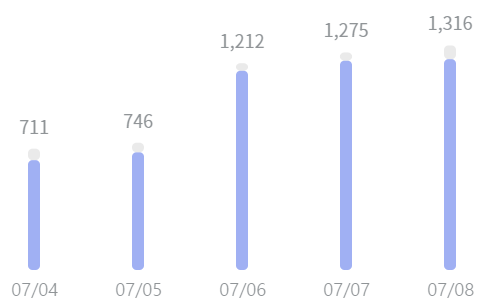

실제 '코로나 라이브'에서 확인할 수 있는 확진자의 수와 일치  
[이미지 출처](https://corona-live.com/)

In [57]:
seoul=df_2[df_2['gubun']=='서울']

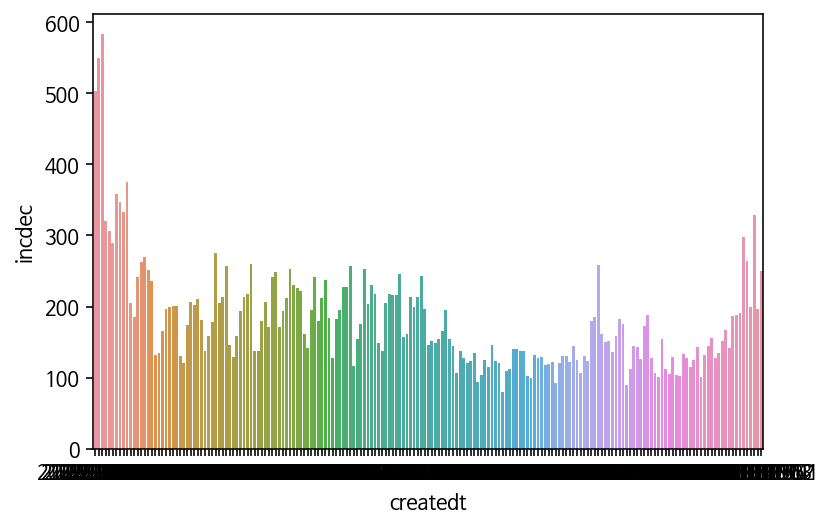

In [58]:
import seaborn as sns
sns.barplot(x=seoul['createdt'],y=seoul['incdec'])

### [시각화]서울 한달 간 신규 및 누적 확진자

In [105]:
insight1=seoul[seoul['createdt']>'2021-06-07']
insight1

,createdt,deathcnt,defcnt,gubun,incdec
17,2021-07-08,519,53577,서울,503
36,2021-07-07,518,53074,서울,550
55,2021-07-06,518,52524,서울,583
74,2021-07-05,518,51941,서울,320
93,2021-07-04,517,51621,서울,307
112,2021-07-03,516,51314,서울,289
131,2021-07-02,516,51026,서울,359
150,2021-07-01,515,50667,서울,347
169,2021-06-30,514,50321,서울,333
188,2021-06-29,513,49987,서울,375


In [60]:
45677-181

45496

In [106]:
insight1['for1month']=insight1['defcnt']-45496
insight1

,createdt,deathcnt,defcnt,gubun,incdec,for1month
17,2021-07-08,519,53577,서울,503,8081
36,2021-07-07,518,53074,서울,550,7578
55,2021-07-06,518,52524,서울,583,7028
74,2021-07-05,518,51941,서울,320,6445
93,2021-07-04,517,51621,서울,307,6125
112,2021-07-03,516,51314,서울,289,5818
131,2021-07-02,516,51026,서울,359,5530
150,2021-07-01,515,50667,서울,347,5171
169,2021-06-30,514,50321,서울,333,4825
188,2021-06-29,513,49987,서울,375,4491


In [108]:
insight1=insight1.sort_values(by=['createdt'],axis=0)

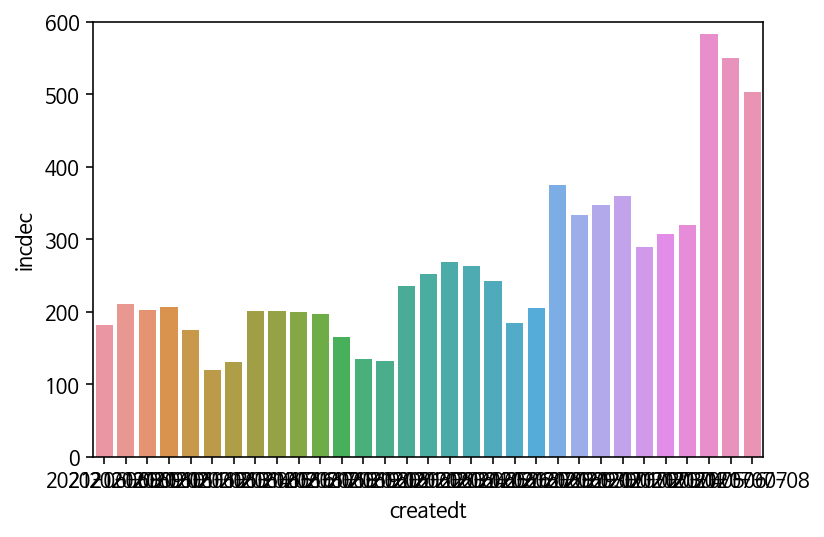

In [63]:
plt.ylim(0, 600)
sns.barplot(x=insight1['createdt'],y=insight1['incdec'])

In [110]:
insight1=insight1.rename(columns={'createdt':'날짜','incdec':'일일확진자','for1month':'누적확진자'})

In [111]:
insight1['날짜']=insight1['날짜'].str[5:].str.replace('-','/')

In [112]:
insight1

,날짜,deathcnt,defcnt,gubun,일일확진자,누적확진자
587,06/08,499,45677,서울,181,181
568,06/09,499,45890,서울,211,394
549,06/10,499,46092,서울,202,596
530,06/11,499,46300,서울,206,804
511,06/12,501,46476,서울,174,980
492,06/13,501,46598,서울,120,1102
473,06/14,502,46731,서울,131,1235
454,06/15,503,46932,서울,201,1436
435,06/16,504,47133,서울,201,1637
416,06/17,505,47333,서울,200,1837


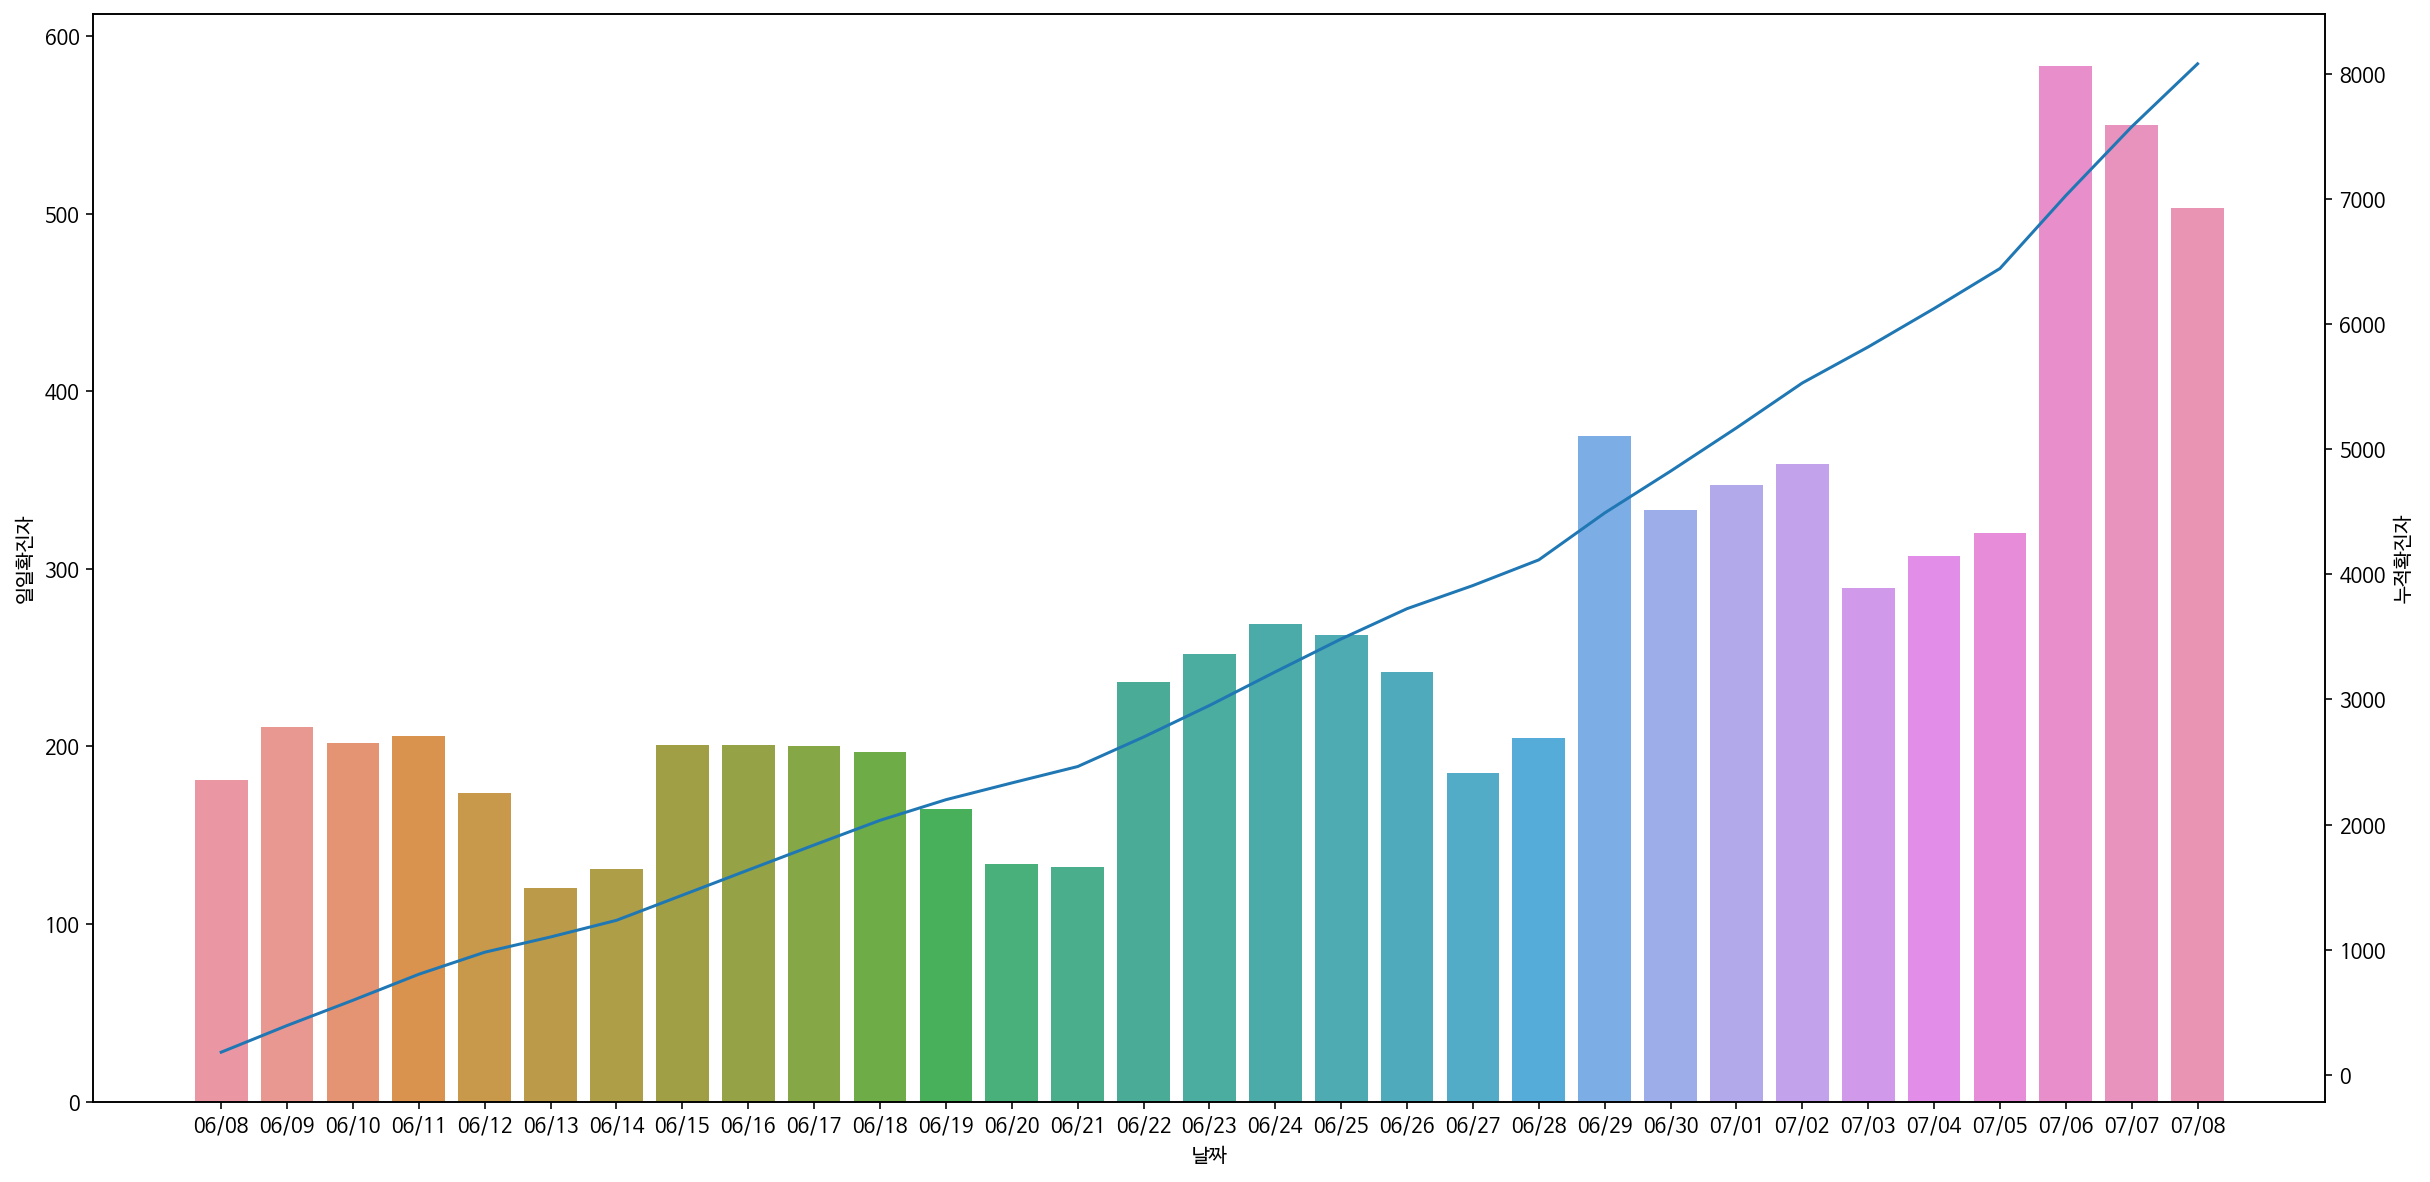

In [116]:
fig,ax0=plt.subplots(figsize=(20,10))

ax1=ax0.twinx()

sns.barplot(x=insight1['날짜'],y=insight1['일일확진자'],ax=ax0)
sns.lineplot(x=insight1['날짜'],y=insight1['누적확진자'],ax=ax1)
plt.show()

In [66]:
insight2=df_2[(df_2['createdt']>'2021-06-07') & (df_2['gubun']=='합계')]
insight2

,createdt,deathcnt,defcnt,gubun,incdec
18,2021-07-08,2036,165344,합계,1316
37,2021-07-07,2034,164028,합계,1275
56,2021-07-06,2033,162753,합계,1212
75,2021-07-05,2032,161541,합계,746
94,2021-07-04,2028,160795,합계,711
113,2021-07-03,2026,160084,합계,743
132,2021-07-02,2025,159342,합계,794
151,2021-07-01,2024,158548,합계,826
170,2021-06-30,2021,157723,합계,761
189,2021-06-29,2018,156961,합계,794


In [67]:
145690-600

145090

In [68]:
insight2['for1month']=insight2['defcnt']-145090
insight2

,createdt,deathcnt,defcnt,gubun,incdec,for1month
18,2021-07-08,2036,165344,합계,1316,20254
37,2021-07-07,2034,164028,합계,1275,18938
56,2021-07-06,2033,162753,합계,1212,17663
75,2021-07-05,2032,161541,합계,746,16451
94,2021-07-04,2028,160795,합계,711,15705
113,2021-07-03,2026,160084,합계,743,14994
132,2021-07-02,2025,159342,합계,794,14252
151,2021-07-01,2024,158548,합계,826,13458
170,2021-06-30,2021,157723,합계,761,12633
189,2021-06-29,2018,156961,합계,794,11871


In [69]:
insight2=insight2.sort_values(by=['createdt'],axis=0)

In [96]:
insight2=insight2.rename(columns={"createdt": "날짜","incdec":"일일확진자","for1month":"누적확진자"})

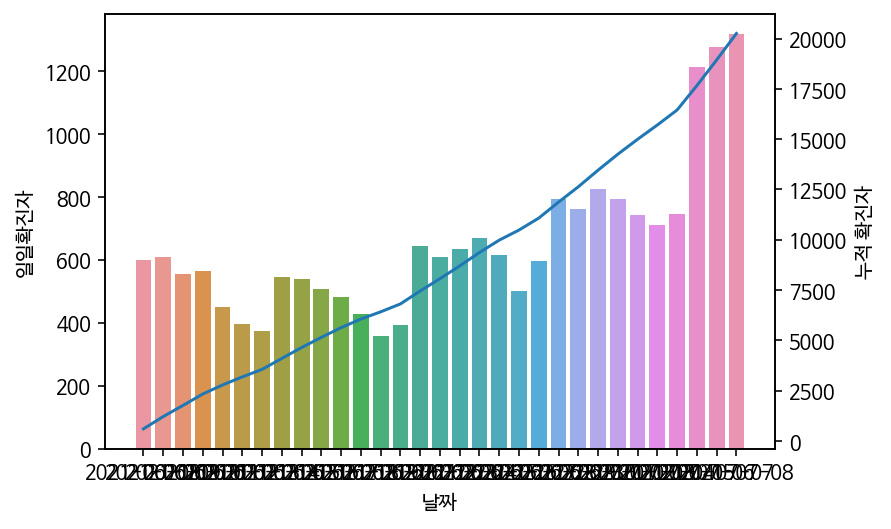

In [100]:

fig,ax0=plt.subplots()
ax1=ax0.twinx()


plt.ylabel("누적 확진자")

sns.barplot(x=insight2['날짜'],y=insight2['일일확진자'],ax=ax0)
sns.lineplot(x=insight2['날짜'],y=insight2['누적확진자'],ax=ax1)
#

### [시각화]

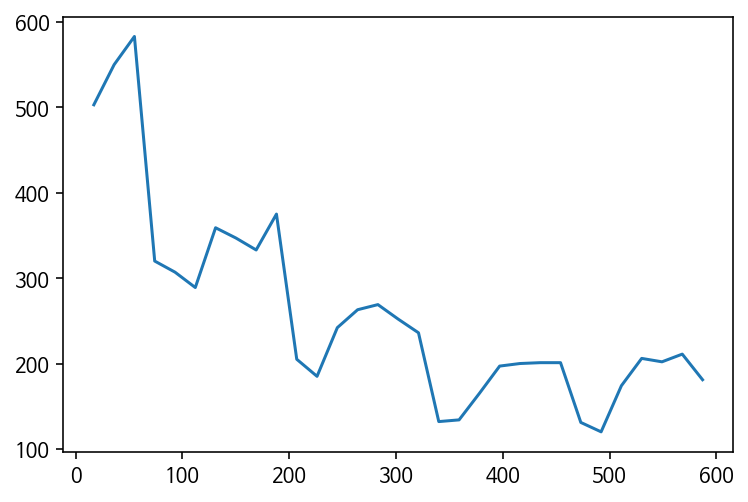

In [71]:
seoul[seoul['createdt']>='2021-06-08']['incdec'].plot()

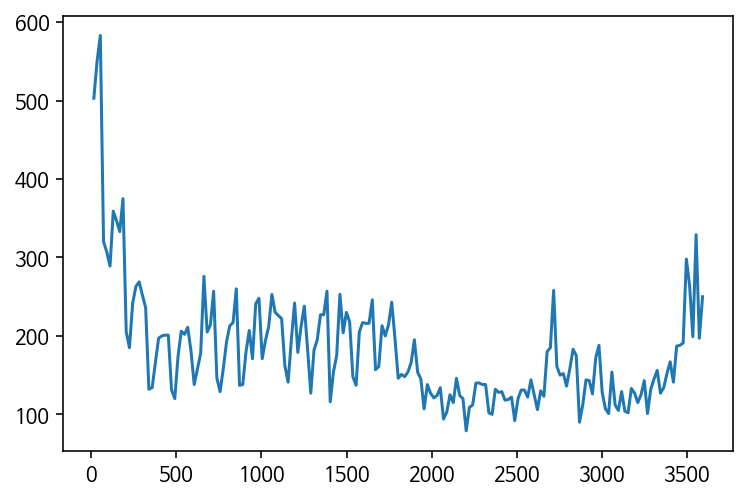

In [72]:
seoul['incdec'].plot()

### 지역별 확진자

In [85]:
insight3=df_2.groupby(['gubun','createdt']).sum()
insight3=insight3.reset_index()
insight3=insight3[(insight3['gubun']!='합계')]
insight3

,gubun,createdt,deathcnt,defcnt,incdec
0,강원,2021-01-01,13,1268,31
1,강원,2021-01-02,15,1301,33
2,강원,2021-01-03,17,1329,28
3,강원,2021-01-04,17,1356,27
4,강원,2021-01-05,17,1372,16
...,...,...,...,...,...
3397,충북,2021-07-04,71,3328,3
3398,충북,2021-07-05,71,3330,2
3399,충북,2021-07-06,71,3335,5
3400,충북,2021-07-07,71,3343,8


In [86]:
insight33=insight3[insight3['createdt']>='2021-06-08'][['gubun','incdec','createdt']]
insight33=insight33.sort_values(by=['createdt'],axis=0)
insight33['createdt']=insight33['createdt'].str[5:].str.replace('-','/')

insight33

,gubun,incdec,createdt
158,강원,30,06/08
1103,광주,7,06/08
914,경북,13,06/08
2426,인천,23,06/08
2615,전남,6,06/08
...,...,...,...
2456,인천,82,07/08
2645,전남,5,07/08
2834,전북,8,07/08
1511,대전,29,07/08


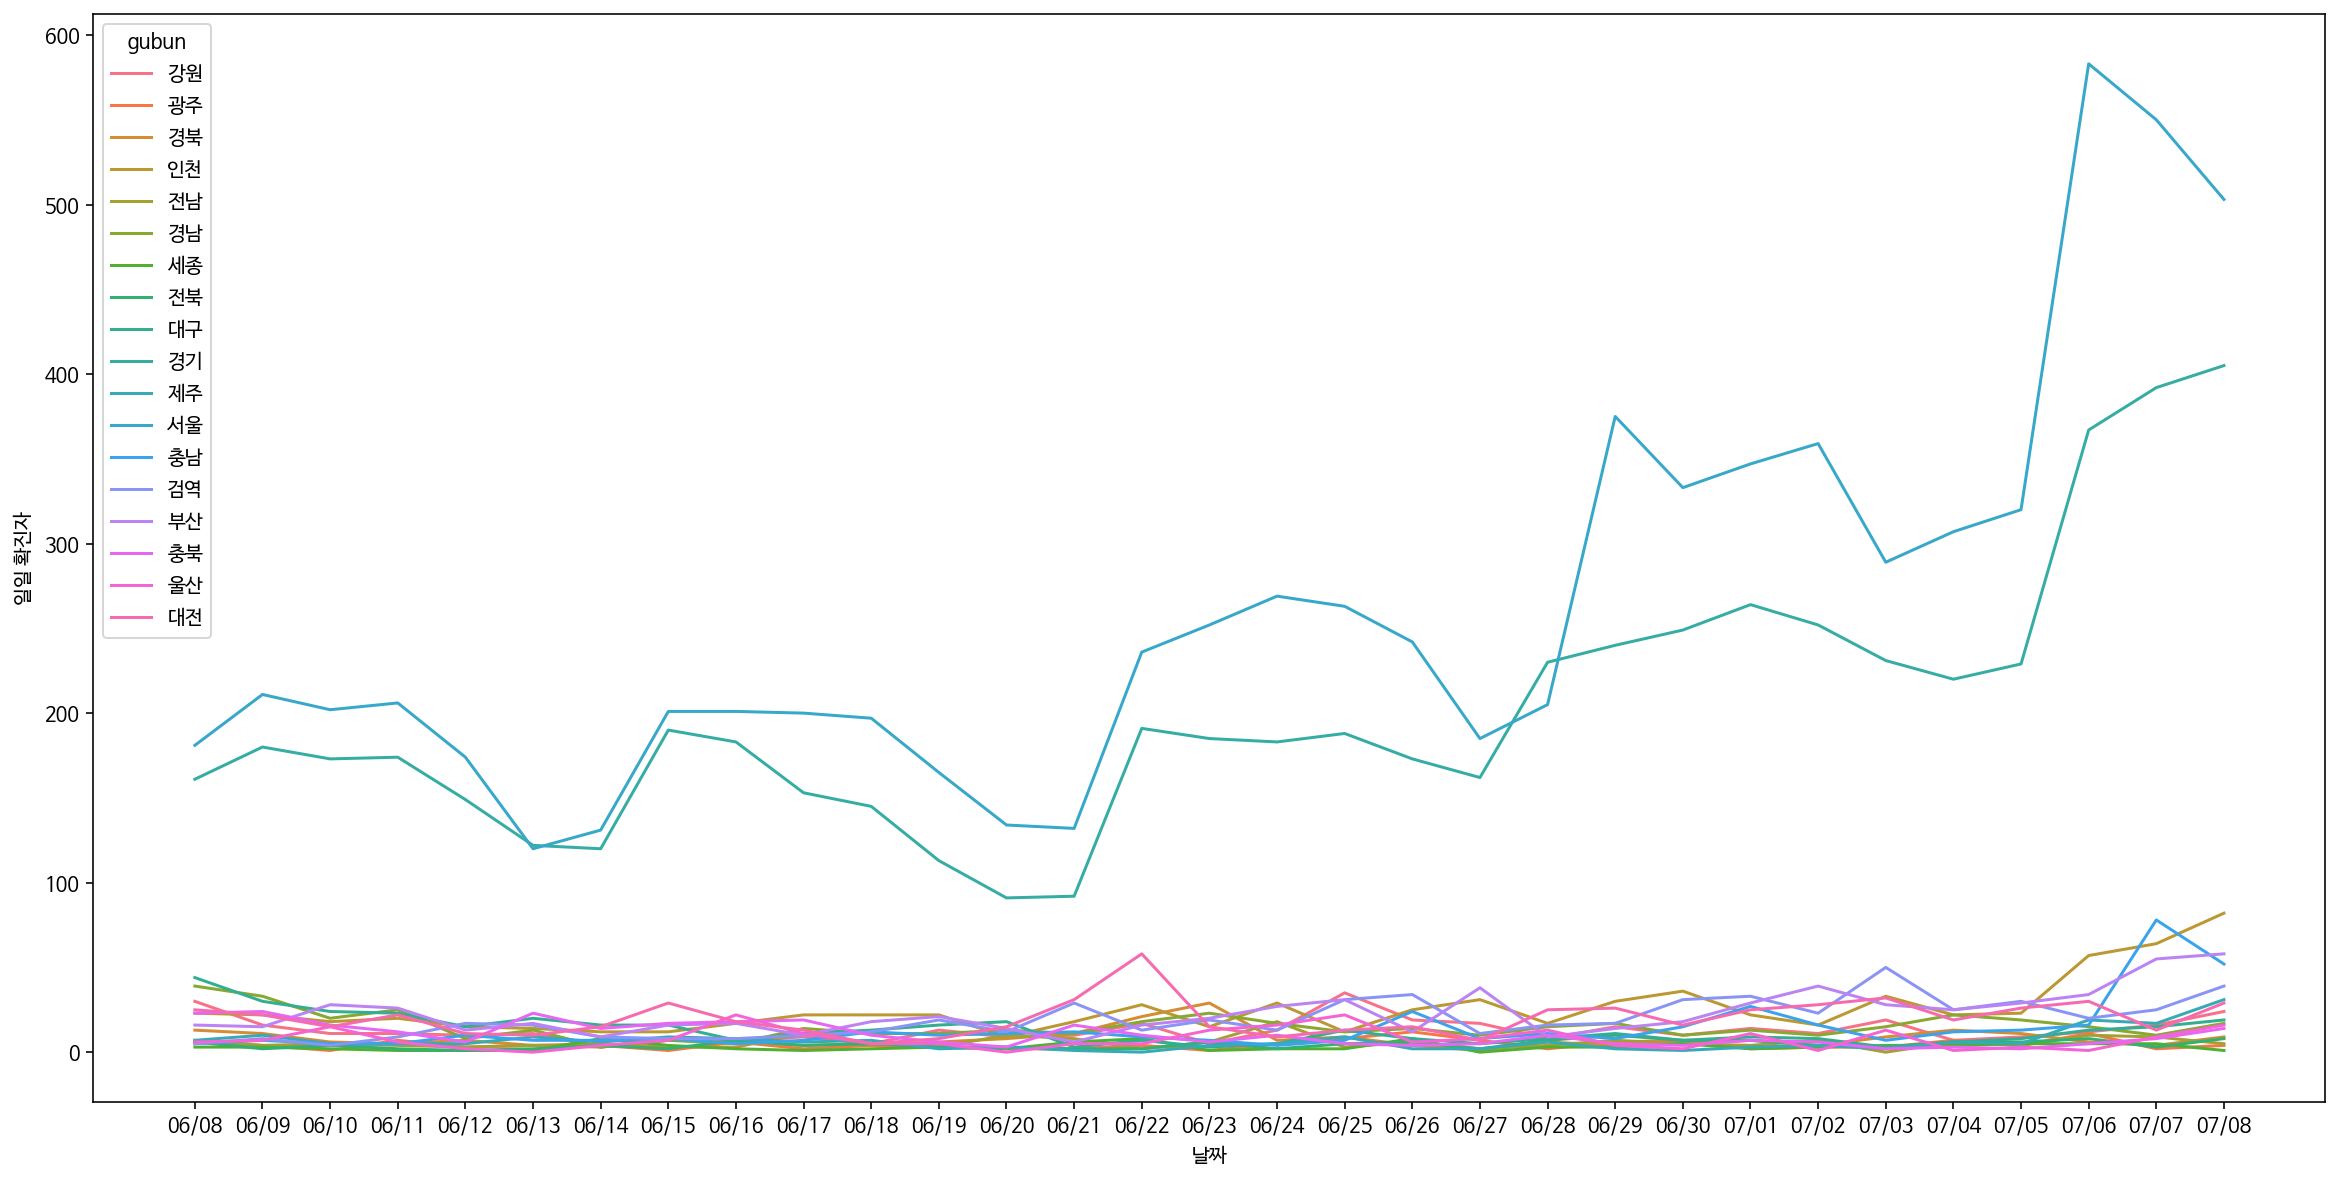

In [87]:
plt.figure(figsize=(20,10))
plt.xlabel("날짜")
plt.ylabel("일일 확진자")
sns.lineplot(x='createdt',y='incdec',hue='gubun',data=insight33);